<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220923.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
from datetime import datetime, date, time, timezone, timedelta

import os
import re

from functools import reduce 
from collections import defaultdict, Counter, ChainMap

# customer analysis

In [2]:
os.listdir()

['.config',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'ecommerce-data.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'test.csv',
 'scanner_data.csv',
 'online_retail_II.xlsx',
 'sample_data']

In [12]:
df = pd.read_csv('scanner_data.csv')
df.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [13]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.columns = [a.lower() if a != 'Customer_ID' else 'id' for a in df.columns]
df.head()

,date,id,transaction_id,sku_category,sku,quantity,sales_amount
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [14]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].to_numpy().astype('datetime64[M]')
df['week'] = df['date'] - df['date'].dt.weekday.astype('timedelta64[D]')
df.head()

,date,id,transaction_id,sku_category,sku,quantity,sales_amount,month,week
0,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,2016-02-01,2016-02-01
1,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,2016-02-01,2016-02-01
2,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01,2016-02-01
3,2016-02-01,3719,4,0H2,549KK,1.0,5.59,2016-02-01,2016-02-01
4,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01,2016-02-01


In [21]:
cnt = df['sku_category'].value_counts().reset_index().rename(columns = {'sku_category':'cnt'})
cnt['ratio'] = round(cnt['cnt']/cnt['cnt'].sum()*100,2)
list_top12 = cnt[cnt['ratio'] >= 2] 
list_top12

,index,cnt,ratio
0,N8U,10913,8.29
1,R6E,5099,3.87
2,LPF,5062,3.84
3,P42,4836,3.67
4,U5F,4570,3.47
5,0H2,4500,3.42
6,IEV,4305,3.27
7,FEW,3164,2.40
8,29A,3033,2.30
9,H15,3011,2.29


In [28]:
df_ = df[df['sku_category'].isin(list_top12['index'])]
list_npu = df_.groupby(['id'])['date'].min().reset_index().rename(columns = {'date':'npu_date'})

df_ = pd.merge(df_, list_npu, 'left', 'id')
df_['days'] = (df_['date'] - df_['npu_date']).dt.days
ret = df_.groupby(['sku_category','days'])['id'].count().reset_index().rename(columns = {'id':'pu'})
ret['ratio'] = ret.groupby(['sku_category'])['pu'].apply(lambda x : round(x/x.max()*100,2))
ret = pd.melt(ret, ['sku_category', 'days'], var_name = 'type')
ret.head()

,sku_category,days,type,value
0,0H2,0,pu,2222.0
1,0H2,1,pu,24.0
2,0H2,2,pu,12.0
3,0H2,3,pu,23.0
4,0H2,4,pu,13.0


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


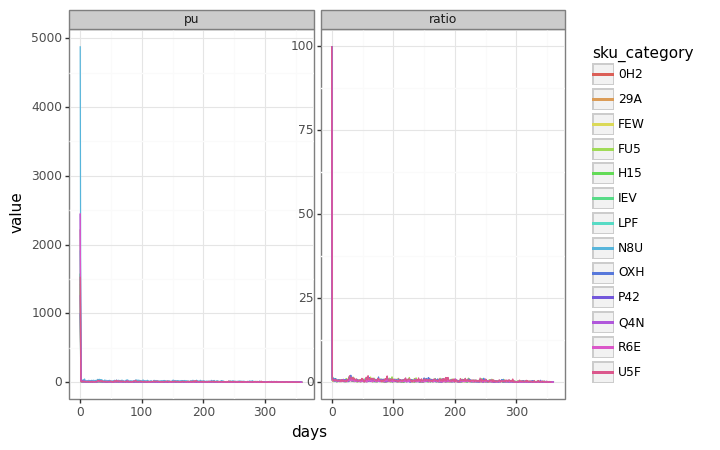

<ggplot: (8744521432457)>

In [29]:
(
    ggplot(ret, aes('days', 'value', color = 'sku_category')) +
    gg.geom_line() +
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw()
)

# iterator

In [31]:
mat = [list('ABC'), list('DEF'), list('GHI')]
a ={letters : [r, c] for r, rows in enumerate(mat) for c, letters in enumerate(rows)}
a

{'A': [0, 0],
 'B': [0, 1],
 'C': [0, 2],
 'D': [1, 0],
 'E': [1, 1],
 'F': [1, 2],
 'G': [2, 0],
 'H': [2, 1],
 'I': [2, 2]}

In [32]:
arr = np.empty([3,3], dtype = 'object')

for k, v in a.items() :
  arr[v[0],v[1]] = k 

arr

array([['A', 'B', 'C'],
       ['D', 'E', 'F'],
       ['G', 'H', 'I']], dtype=object)

In [35]:
def add_arthor_with_name(name) :
  def add_arthor(func) :
    def wrapper(*args, **kwargs) :
      return name + '\n' + func(*args, **kwargs)
    return wrapper
  return add_arthor

def add_arthor(func) :
  def wrapper(*args, **kwargs) :
    return 'park' + '\n' + func(*args, **kwargs)
  return wrapper

def calc_time(func) :
  def wrapper(*args, **kwargs) :
    a = datetime.now()
    func(*args, **kwargs)
    b = datetime.now()
    print({b-a})
    return func(*args, **kwargs)
  return wrapper

@calc_time
@add_arthor_with_name('kim')
def get_title(title) :
  return title

@calc_time
@add_arthor
def get_title2(t1, t2) :
  return t1 + ' ' + t2

In [36]:
print(get_title('너 차갑게 돌아서도'))
print(get_title2('내안의 넌', '달라지는게 아니라고'))

{datetime.timedelta(microseconds=9)}
kim
너 차갑게 돌아서도
{datetime.timedelta(microseconds=9)}
park
내안의 넌 달라지는게 아니라고
